<a href="https://colab.research.google.com/github/MePrachi/AWS_Codesuite/blob/main/multi_agent_system_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POC for implementing a multi agent system using langgraph

In [ ]:
!pip install langgraph langchain-core langchain_groq --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from IPython.display import display, Image


#### 1. Define the available agents (agent registry)

In [ ]:
members = ["ticket_summarizer", "root_cause_analyzer"]
options = members + ["FINISH"]

In [ ]:
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed

In [ ]:
# Define the system prompt for supervisor agent

system_prompt = (
    f"You are a supervisor tasked with managing a conversation between the following workers: {members}."
    "Given the following user request, respond with the worker to act next."
    "Each worker will perform a task and respond with their results and status."
    "When finished, respond with FINISH"
)

In [ ]:
class Router(TypedDict):
  """Worker to route to next. If no workers needed, route to FINISH"""
  next: Literal[*options]

In [ ]:
from google.colab import userdata
from langchain_groq import ChatGroq

API_KEY = userdata.get('GROQ_API_KEY')  # Must match the name you used in secrets
llm = ChatGroq(groq_api_key=API_KEY, model_name="gemma2-9b-it")

In [ ]:
class State(MessagesState):
  next: str

In [ ]:
# Define the supervisor node. Its job is to check the messages and direct the flow to one of the agents.
# Or terminate the flow if task is complete
def supervisor_node(state: State) -> Command[Literal[*members,"__end__"]]:
  messages = [
      {"role": "system", "content": system_prompt}
  ] + state["messages"]

  response = llm.with_structured_output(Router).invoke(messages)

  print(response)
  goto = response["next"]
  if goto == "FINISH":
    goto = END

  return Command(goto=goto, update={**state,"next": goto})

#### 2. Next, create individual agents

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

### TS agent
ticket_summarizer_agent = create_react_agent(
    llm,tools=[], prompt="You can summarize tickets. Use the ticket content provided and summarize it."
)

### RCA agent
root_cause_analyzer_agent = create_react_agent(
    llm,tools=[], prompt="You can find root cause of the issue. Find root cause in the provide text."
)

# -----Create nodes below------

# Ticket summarizer node
def ticket_summarizer_node(state: State) -> Command[Literal["supervisor"]]:
  # result = "Dummy Ticket summarized result" # Replace with actual call to for ticket summarizer
  result = ticket_summarizer_agent.invoke(state)
  return Command(goto="supervisor", update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="ticket_summarizer")
            ]
        }
        )

# Root cause analyzer node
def root_cause_analyzer_node(state: State) -> Command[Literal["supervisor"]]:
  # result = "Dummy Root cause analysis result" # Replace with actual call to for root cause analyzer
  result = root_cause_analyzer_agent.invoke(state)
  return Command(goto="supervisor", update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="root_cause_analyzer")
            ]
        }
        )

#### 3. Next, create the graph

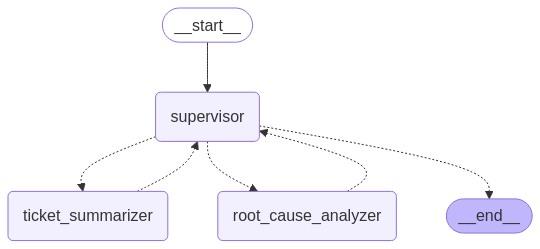

In [ ]:
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("ticket_summarizer", ticket_summarizer_node)
builder.add_node("root_cause_analyzer", root_cause_analyzer_node)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

#### 4. Invoke the agents with a sample ticket payload.

In [ ]:
ticket = """
Problem Summary

Multiple user experience issues reported with the Clips experiment feature:

    Video display issues with improper full-screen rendering affecting ASIN carousel visibility
    Scroll functionality problems with video content
    UI/UX concerns including excessive gaps between videos, carousel padding issues
    Functionality issues with mute/unmute persistence and video playback behavior
    Interface elements sizing and positioning problems
    Root cause appears to be related to height calculation differences between iOS and Android native components
"""

for s in graph.stream(
    {"messages": [("user", f"Ticket data: {ticket}")]}, subgraphs=True
):
    print(s)
    print("----")

{'next': 'ticket_summarizer'}
((), {'supervisor': {'messages': [HumanMessage(content='Ticket data: \nProblem Summary\n\nMultiple user experience issues reported with the Clips experiment feature:\n\n    Video display issues with improper full-screen rendering affecting ASIN carousel visibility\n    Scroll functionality problems with video content\n    UI/UX concerns including excessive gaps between videos, carousel padding issues\n    Functionality issues with mute/unmute persistence and video playback behavior\n    Interface elements sizing and positioning problems\n    Root cause appears to be related to height calculation differences between iOS and Android native components\n', additional_kwargs={}, response_metadata={}, id='c8247c47-8336-4876-8a40-6e26623f7af3')], 'next': 'ticket_summarizer'}})
----
(('ticket_summarizer:8ebb81e9-c880-eb11-e1c8-0ad98aabab94',), {'agent': {'messages': [AIMessage(content='The Clips experiment feature is experiencing multiple user experience issues ac